<a href="https://colab.research.google.com/github/Alokksinha00/test/blob/master/Softmax_flash_attn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Algorithm
Matrices Q, K, V  $\in$ $R^{N×𝑑}$ in HBM, on-chip SRAM of size $M$.
1. Set block sizes $B_{c}$= $\lceil\frac{M}{4d}\rceil$ , $B_{r}$= min($\lceil\frac{M}{4d}\rceil$ ,d). 4d is required to divide to accomodate all query, key, value and output blocks which can be minimum 4*d at a time in SRAM
2. Initialize O = $[0]_{𝑁 ×𝑑}$  $\in$ $R^{N×𝑑}$ , $l=(0)_{N}$ $\in$ $R^{N}$, m=$(-∞)_{N}$ $\in$ $R^{N}$ in HBM.
3. Divide $Q$ into $T_{r}$= $⌈\frac{N}{B_{r}}\rceil$ blocks $Q1$, . . . , $Q_{Tr}$ of size $𝐵_{𝑟}$ x $d$ each, and divide K, V in to $𝑇_{𝑐}$ = $⌈\frac{N}{B_{c}}⌉$  blocks
$K_{1}$, . . . , $K_{Tc}$ and $V_{1}$, . . . , $V_{𝑇𝑐}$, of size $B_{c}$ × $𝑑$ each.
4. Divide $O$ into $𝑇_{𝑟}$ blocks $O_{1}$, . . . , $O_{𝑇𝑟}$ of size $𝐵_{𝑟}$ × $𝑑$ each, divide $l$ into$𝑇_{𝑟}$ blocks $l_{1}$, . . . , $l_{𝑇𝑟}$ of size $B_{r}$ each
divide $𝑚$ into $T_{r}$ blocks $m_{1}$, . . . , $m_{Tr}$ of size $B_{r}$ each.

#Note:
1. Take an example of $N=4,\ d=4,\ B_{r}=2\ and\ B_{c}=2$
2. $Q,\ K,\ V$ are sliced rowwise
3. $P = softmax(QK^{T})$ and  $O = PV$




5. $for$ $1 {≤ } 𝑗 ≤ 𝑇_{c}$ do

 6. Load $K_{j}$, $V_{j}$ from HBM to on-chip SRAM.
 7. $for$ $1 {≤} 𝑖 {≤} 𝑇_{r}$ do

     8. Load $Q_{i}, O_{𝑖}, l_{i}$ and $𝑚_{i}$ from HBM to on-chip SRAM.
     9. On chip, compute $S_{𝑖𝑗} = Q_{𝑖}K_{j}^{𝑇}$ $\in$ $R^{B_{r}×B_{c}}$
     10. On chip, compute
\begin{equation}
m̃_{ij} = rowmax(S_{ij}) ∈ R^{Br},\\P̃_{ij} = exp(S_{ij}- m̃_{ij}), \in R^{B_{r}×B_{c}} (pointwise),\\l_{ij}=rowsum(P̃_{ij}) \in R^{Br}
\end{equation}
      11. On chip, compute
      \begin{equation}
      m_{i}^{new}=max(m_{i}, m̃_{ij})∈ R^{Br}, \\l_i^{new} = exp(m_i-m_i^{new})l_i + exp(m̃_{ij}-m_i^{new})l_{ij} \in R^{Br}
      \end{equation}
      12. Write
      \begin{equation}
      O_{i}⟵ diag(l_i^{new})^{-1} (diag(l_i) exp(m_i-m_i^{new})O_i + exp(m̃_{ij}-m_i^{new})P̃_{ij}V_j)
      \end{equation} to HBM
      13. Write
      \begin{equation}
      l_i⟵ l_i^{new} ,\ m_i⟵m_i^{new}
      \end{equation} to HBM
      
    $end \ for$

  $end \ for$

  return $O$

  
       
     

#Simplified
1. Outer loop is over $K,\ V$ blocks and loads them from HBM into SRAM
2. Inner loop is over $Q$ blocks and load them from HBM into SRAM
3. Step 10 has $S- m$ term on exponent is to handle underflow or overflow cases and rowsum $l_{ij}$ is done for denominator of softmax for each block
4. Step 11 calculates the total denominator for softmax and it is done by running algebric sum.
5. It does the scaling trick in step 11 and uses previous value.
Since maximum value per row changes when we combine all the blocks(tiles), it has to be corrected. We have exponent terms because we are combining values that were normalised with different maximum values

  $l_i^{new}$ = (exponent term1) * previous $l$ + (exponent term2) * current $l$

  both exponent term 1 and 2 has $m_i^{new}$ term subtracted as this is a new maximum for the combined row.

#Next picture is a depiction of the scaling trick (not considering maximum value logic)

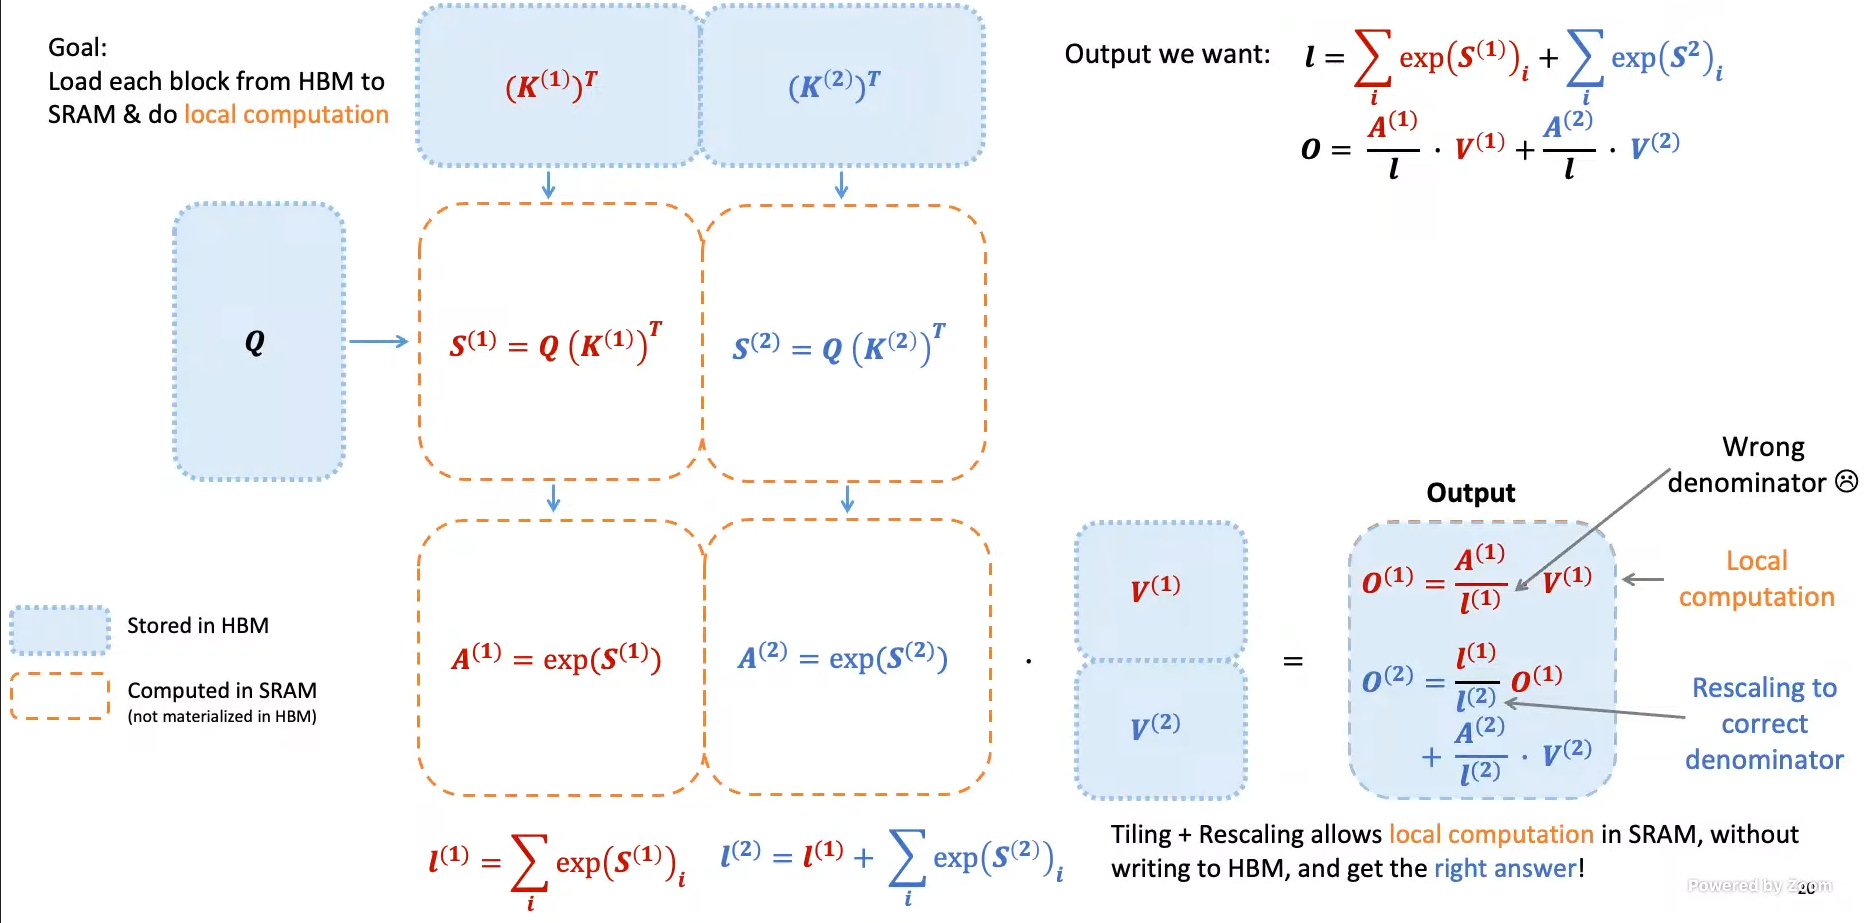

In [15]:
class FlashAttention(nn.Module):
  def __init__(self, N, d, br, bc):
    super(FlashAttention, self).__init__()
    self.l = torch.zeros(N,1)
    self.m = torch.full((N,1), float('-inf'))
    self.O = torch.zeros(N, d)
    self.Num_blocks_r = math.ceil(N/br)
    self.Num_blocks_c = math.ceil(N/bc)
    self.br = br
    self.bc = bc

  def forward(self, Q, K, V):
    for j in range(self.Num_blocks_c):
      c_index = j*self.bc
      # loads K and V from HBM in blocks
      K_j = K[c_index:c_index + self.bc]
      V_j = V[c_index:c_index + self.bc]

      for i in range(self.Num_blocks_r):
        r_index = i*self.br
        # load l, m, O and Q
        l_i = self.l[r_index:r_index + self.br]
        m_i = self.m[r_index:r_index + self.br]
        O_i = self.O[r_index:r_index + self.br]
        Q_i = Q[r_index:r_index + self.br]
        S_ij = torch.matmul(Q_i, K_j.transpose(-2, 1))
        # local row max
        m_ij = S_ij.max(dim=1, keepdim=True)
        # local softmax numerator
        P_ij = torch.exp(S_ij - m_ij.values.reshape(-1, 1))
        # local softmax denominator
        l_ij = torch.sum(P_ij, dim=1)
        # running max value
        m_i_new = torch.max(m_i.reshape(-1,1), m_ij.values)

        # running softmax denominator
        l_i_new = torch.exp(m_i.reshape(-1,1) - m_i_new) * l_i.reshape(-1,1) + torch.exp(m_ij.values - m_i_new) * l_ij.reshape(-1,1)
        # current Tile o/p (o_i) = [(Previous denom*scaling factor_1* previous Tile o/p) +
        #                            (P*V*scaling factor_2)] /New denominator
        ####### first term #######
        # scaled attention score O_i of prev block
        l_i_new_inv = torch.diag(1.0 / torch.flatten(l_i_new))
        scaled_O_i = torch.exp(m_i.reshape(-1,1) - m_i_new) * O_i
        pre_softmax_numer = (torch.diag(torch.flatten(l_i))).to(scaled_O_i.dtype)
        pre_softmax = torch.matmul(pre_softmax_numer.transpose(-2, -1), scaled_O_i)
        pre_softmax_scaled = torch.matmul(l_i_new_inv.transpose(-2, -1) ,pre_softmax)
        ####### second term #######
        # scaled attention score of current block
        scaled_P_V = torch.exp(m_ij.values - m_i_new) * (P_ij @ V_j)
        curr_softmax_scaled = torch.matmul(l_i_new_inv.transpose(-2, -1), scaled_P_V)

        O_i = pre_softmax_scaled + curr_softmax_scaled
        #writing l, m and O back to HBM
        self.l[r_index:r_index + self.br] = l_i_new
        self.m[r_index:r_index + self.br] = m_i_new
        self.O[r_index:r_index + self.br] = O_i
        # print(f'O_i val\n{O_i}')
        # print(f'O val\n{self.O}')

    return self.O


In [17]:
# # query (N x d), key (N X d), value (N x d)
# query = torch.tensor([[2, 3, 4, 5], [6, 7, 8, 9], [11, 5, 9, 3], [8, 10, 9, 2]], dtype=float)
# key = torch.tensor([[1, 2, 8, 9], [7, 3, 9, 1], [6, 7, 8, 9], [2, 3, 4, 5]], dtype=float)
# value = torch.tensor([[5, 6, 9, 1], [8, 10, 9, 2], [11, 5, 9, 3], [12, 6, 9, 5]], dtype=float)

# # query (N x d), key (N X d), value (N x d)
# query =  torch.tensor([[1, 2, 8, 9], [7, 3, 9, 1], [6, 7, 8, 9], [2, 3, 4, 5]], dtype=float)
# key = torch.tensor([[5, 6, 9, 1], [8, 10, 9, 2], [11, 5, 9, 3], [12, 6, 9, 5]], dtype=float)
# value = torch.tensor([[2, 3, 4, 5], [6, 7, 8, 9], [11, 5, 9, 3], [8, 10, 9, 2]], dtype=float)

# query (N x d), key (N X d), value (N x d)
# query =  torch.tensor([[11, 32, 88, 90], [7, 33, 10, 61], [36, 72, 28, 29], [22, 33, 74, 20]], dtype=float)
# key = torch.tensor([[50, 65, 9, 15], [54, 10, 9, 23], [11, 53, 42, 36], [12, 32, 7, 59]], dtype=float)
# value = torch.tensor([[29, 39, 44, 57], [6, 3, 98, 49], [11, 55, 29, 13], [88, 10, 9, 2]], dtype=float)

# # query (N x d), key (N X d), value (N x d)
query = torch.tensor([[0.2928, 0.0902, 0.3633],
        [0.0298, 0.2964, 0.6855],
        [0.9710, 0.4490, 0.2797],
        [0.8274, 0.4298, 0.0727],
        [0.5928, 0.0315, 0.1161]])
key = torch.tensor([[0.5862, 0.6762, 0.5282],
        [0.8007, 0.7378, 0.5190],
        [0.6961, 0.0784, 0.5855],
        [0.0155, 0.8816, 0.8656],
        [0.2977, 0.0771, 0.6828]])
value = torch.tensor([[0.9640, 0.2854, 0.7072],
        [0.9502, 0.3913, 0.5239],
        [0.8375, 0.0288, 0.2683],
        [0.6298, 0.9237, 0.0070],
        [0.8387, 0.5388, 0.3965]])
N, d = query.shape
block_size_c = 2
block_size_r = 2
print(f'dimension seqlen {N}, embed_dim {d}')
print(f'block_size_c, block_size_r {block_size_c, block_size_r}')


Flashattn = FlashAttention(N, d, block_size_r, block_size_c)
attention_score = Flashattn(query, key, value)
print(f'Attention score \n {attention_score}')

dimension seqlen 5, embed_dim 3
block_size_c, block_size_r (2, 2)
Attention score 
 tensor([[0.8467, 0.4289, 0.3842],
        [0.8314, 0.4721, 0.3606],
        [0.8659, 0.4000, 0.4171],
        [0.8649, 0.4023, 0.4161],
        [0.8585, 0.3983, 0.4027]])


In [18]:
class DotProductAttention(nn.Module):
    def __init__(self):
        super(DotProductAttention, self).__init__()

    def forward(self, query, key, value):
        # Calculate the dot products between query and key
        scores = torch.matmul(query, key.transpose(-2, -1))

        # Apply softmax to get the attention weights
        attention_weights = F.softmax(scores, dim=-1)

        # Multiply the attention weights with the value
        context = torch.matmul(attention_weights, value)

        return context, attention_weights

# Example usage
# query (N x d), key (N X d), value (N x d)
# query =  torch.tensor([[1, 2, 8, 9], [7, 3, 9, 1], [6, 7, 8, 9], [2, 3, 4, 5]], dtype=float)
# key = torch.tensor([[5, 6, 9, 1], [8, 10, 9, 2], [11, 5, 9, 3], [12, 6, 9, 5]], dtype=float)
# value = torch.tensor([[2, 3, 4, 5], [6, 7, 8, 9], [11, 5, 9, 3], [8, 10, 9, 2]], dtype=float)

# # query (N x d), key (N X d), value (N x d)
# query =  torch.tensor([[1, 2, 8, 9], [7, 3, 9, 1], [6, 7, 8, 9], [2, 3, 4, 5]], dtype=float)
# key = torch.tensor([[5, 6, 9, 1], [8, 10, 9, 2], [11, 5, 9, 3], [12, 6, 9, 5]], dtype=float)
# value = torch.tensor([[2, 3, 4, 5], [6, 7, 8, 9], [11, 5, 9, 3], [8, 10, 9, 2]], dtype=float)

# # query (N x d), key (N X d), value (N x d)
# query =  torch.tensor([[11, 32, 88, 90], [7, 33, 10, 61], [36, 72, 28, 29], [22, 33, 74, 20]], dtype=float)
# key = torch.tensor([[50, 65, 9, 15], [54, 10, 9, 23], [11, 53, 42, 36], [12, 32, 7, 59]], dtype=float)
# value = torch.tensor([[29, 39, 44, 57], [6, 3, 98, 49], [11, 55, 29, 13], [88, 10, 9, 2]], dtype=float)

# # query (N x d), key (N X d), value (N x d)
query = torch.tensor([[0.2928, 0.0902, 0.3633],
        [0.0298, 0.2964, 0.6855],
        [0.9710, 0.4490, 0.2797],
        [0.8274, 0.4298, 0.0727],
        [0.5928, 0.0315, 0.1161]])
key = torch.tensor([[0.5862, 0.6762, 0.5282],
        [0.8007, 0.7378, 0.5190],
        [0.6961, 0.0784, 0.5855],
        [0.0155, 0.8816, 0.8656],
        [0.2977, 0.0771, 0.6828]])
value = torch.tensor([[0.9640, 0.2854, 0.7072],
        [0.9502, 0.3913, 0.5239],
        [0.8375, 0.0288, 0.2683],
        [0.6298, 0.9237, 0.0070],
        [0.8387, 0.5388, 0.3965]])
attention = DotProductAttention()
context, attention_weights = attention(query, key, value)
print(f' Attention w/o softmax trick\n {context}')
print(f' Softmax w/o optimization {attention_weights}')


 Attention w/o softmax trick
 tensor([[0.8467, 0.4289, 0.3842],
        [0.8314, 0.4721, 0.3606],
        [0.8659, 0.4000, 0.4171],
        [0.8649, 0.4023, 0.4161],
        [0.8585, 0.3983, 0.4027]])
 Softmax w/o optimization tensor([[0.2016, 0.2151, 0.2014, 0.1964, 0.1856],
        [0.1948, 0.1985, 0.1703, 0.2566, 0.1798],
        [0.2261, 0.2855, 0.1955, 0.1566, 0.1363],
        [0.2278, 0.2792, 0.1938, 0.1590, 0.1403],
        [0.2092, 0.2378, 0.2206, 0.1561, 0.1762]])
